### Description

In [172]:
import math
import pandas as pd
import pandas_datareader as web
import numpy as np
import datetime as dt
import time
import pickle
from datetime import timedelta
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.layers import Dropout
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [173]:
##Initialize the parameters..
today = dt.date.today()
preDayDate = today - timedelta(1)

sDate = '2010-01-01'
eDate = preDayDate
retryCount = 3
datasource = 'yahoo'
stock = 'AAPL'

## hyperparameters..
batchsize=10
epochs=5
slots=60
LSTMNeurons=50
denseNeurons=25

In [174]:
df = web.DataReader(stock, data_source=datasource, start=sDate, end=eDate, retry_count=retryCount)

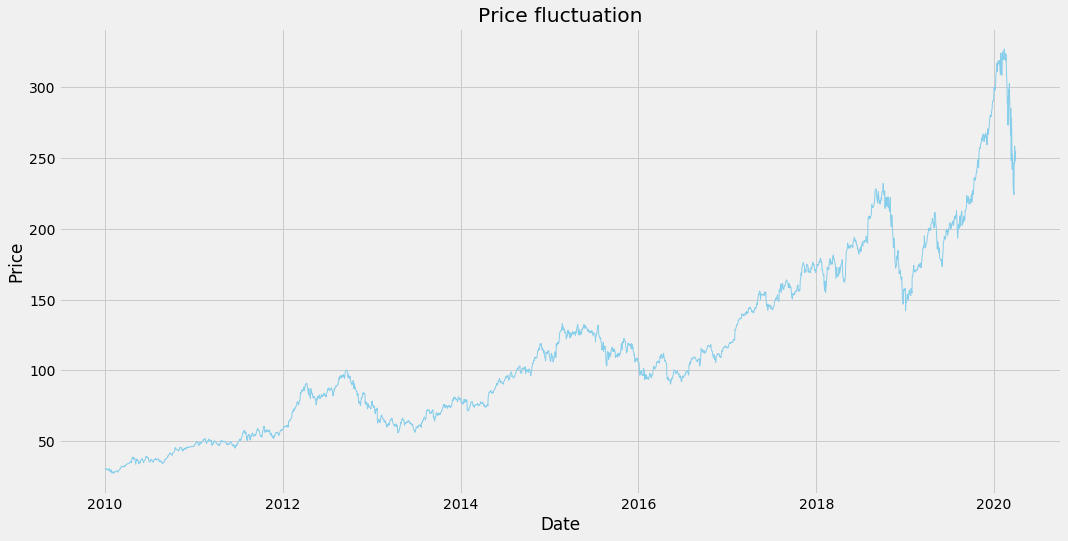

In [175]:
plt.figure(figsize=(16,8))
plt.title('Price fluctuation')
plt.plot(df['Close'],color='skyblue', linewidth=1)
plt.xlabel('Date')
plt.ylabel('Price')

plt.show()

In [176]:
data = df.filter(['Close'])
dataset = data.values

train_data_len = math.ceil(len(dataset) * 0.8)

## Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaler_data = scaler.fit_transform(dataset)

In [177]:
train_data = scaler_data[0:train_data_len, :]

In [178]:
x_train = []
y_train = []
i=0
for i  in range(slots, len(train_data)):
    #print(i)
    x_train.append(train_data[i-slots:i,0])
    y_train.append(train_data[i,0])

In [179]:
x_train, y_train = np.array(x_train), np.array(y_train)

In [180]:
#reshape the array
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [181]:
def build_and_compile_model():
    ## Build the model
    model = Sequential()

    model.add(LSTM(LSTMNeurons, return_sequences=True, input_shape=(x_train.shape[1], 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(LSTMNeurons, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(denseNeurons))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    
    ## Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    ## Return the model
    return model    

In [182]:
def prepare_test_data():
    ## create test dataset
    test_data = scaler_data[train_data_len - slots: ,:]

    x_test = []
    y_test = dataset[train_data_len: ,:]
    i=0
    for i  in range(slots, len(test_data)):
        #print(i)
        x_test.append(test_data[i - slots:i,0])
     
    ## convert to array and reshape..
    x_test = np.array(x_test)
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
    return x_test, y_test

In [183]:
def calculate_rmse(predictions, y_test):
    ## calculate RMSE
    rmse = np.sqrt(np.mean(predictions - y_test)**2)
    
    return rmse

In [184]:
def fit_model_and_make_prediction(model, x_test, b, e):
    ## fit the model
    t1 = time.time()
    model.fit(x_train, y_train, batch_size=b, epochs=e)
    t2 = time.time()
    total_time_taken = (t2-t1)
    
    ## Prediction..
    predictions = model.predict(x_test)
    predictions = scaler.inverse_transform(predictions)
    
    return predictions, total_time_taken

In [185]:
def do_predictions(model, x_test):
    ## Prediction..
    predictions = model.predict(x_test)
    predictions = scaler.inverse_transform(predictions)
    
    return predictions

In [186]:
def same_model(model, b, e):
    ## fit the model
    model.fit(x_train, y_train, batch_size=b, epochs=e)
    
    model_name = 'stockPicePrediction.sav'
    pickle.dump(model, open(model_name, 'wb'))    

In [ ]:
list_rmse = []
ep = [20,25,30,35,40,45,50]
bs = [30,35,40,45,50,55,60]

#===========
#model = build_and_compile_model()
#same_model(model, 30, 20)
#============

def call_iterations():    
    for e in ep:
        for b in bs:
            ## get the model
            model = build_and_compile_model()
        
            ## prepare the test data..
            x_test, y_test = prepare_test_data()
        
            ## fit the model
            predictions, total_time_taken = fit_model_and_make_prediction(model, x_test, b, e)
        
            ## make predictions
            #predictions = do_predictions(fit_model, x_test)
        
            ## calculate rmse.
            rmse = calculate_rmse(predictions, y_test)
                
            r = []
            r.append(e)
            r.append(b)
            r.append(rmse)
            r.append(total_time_taken)
            list_rmse.append(r)

            

call_iterations()

Epoch 1/20
2004/2004 [==============================] - 44s 22ms/step - loss: 0.0059
Epoch 2/20
2004/2004 [==============================] - 23s 11ms/step - loss: 0.0016
Epoch 3/20
2004/2004 [==============================] - 22s 11ms/step - loss: 0.0012
Epoch 4/20
2004/2004 [==============================] - 23s 11ms/step - loss: 0.0011
Epoch 5/20
2004/2004 [==============================] - 23s 11ms/step - loss: 0.0010
Epoch 6/20
2004/2004 [==============================] - 22s 11ms/step - loss: 8.8502e-04
Epoch 7/20
2004/2004 [==============================] - 21s 11ms/step - loss: 7.4848e-04
Epoch 8/20
2004/2004 [==============================] - 21s 11ms/step - loss: 7.4247e-04
Epoch 9/20
2004/2004 [==============================] - 22s 11ms/step - loss: 6.8878e-04
Epoch 10/20
2004/2004 [==============================] - 22s 11ms/step - loss: 6.7508e-04
Epoch 11/20
2004/2004 [==============================] - 22s 11ms/step - loss: 6.8320e-04
Epoch 12/20
2004/2004 [================

2004/2004 [==============================] - 28s 14ms/step - loss: 6.7689e-04
Epoch 14/20
2004/2004 [==============================] - 29s 14ms/step - loss: 6.7895e-04
Epoch 15/20
2004/2004 [==============================] - 23s 12ms/step - loss: 6.6692e-04
Epoch 16/20
2004/2004 [==============================] - 23s 12ms/step - loss: 6.1857e-04
Epoch 17/20
2004/2004 [==============================] - 23s 12ms/step - loss: 6.2190e-04
Epoch 18/20
2004/2004 [==============================] - 23s 12ms/step - loss: 5.8671e-04
Epoch 19/20
2004/2004 [==============================] - 23s 12ms/step - loss: 5.9255e-04
Epoch 20/20
2004/2004 [==============================] - 23s 12ms/step - loss: 5.5533e-04
Epoch 1/20
2004/2004 [==============================] - 42s 21ms/step - loss: 0.0077
Epoch 2/20
2004/2004 [==============================] - 23s 12ms/step - loss: 0.0016
Epoch 3/20
2004/2004 [==============================] - 26s 13ms/step - loss: 0.0014
Epoch 4/20
2004/2004 [===============

In [ ]:
list_rmse

rmse_df = pd.DataFrame(list_rmse)
rmse_df.columns = ['Epoch','Batch','RMSE','Time']

In [ ]:
rmse_df.sort_values(by=['RMSE'],ascending=True, inplace=True)
rmse_df

In [22]:
## Build the model
#model = Sequential()

#model.add(LSTM(LSTMNeurons, return_sequences=True, input_shape=(x_train.shape[1], 1)))
#model.add(Dropout(0.2))
#model.add(LSTM(LSTMNeurons, return_sequences=False))
#model.add(Dropout(0.2))
#model.add(Dense(denseNeurons))
#model.add(Dropout(0.2))
#model.add(Dense(1))

In [23]:
## Compile the model
#model.compile(optimizer='adam', loss='mean_squared_error')

In [24]:
#import datetime as dt
## train the model
#t1 = dt.datetime.now()
#print("Model compilation started at " + str.format(str(t1)))
#model.fit(x_train, y_train, batch_size=batchsize, epochs=epochs)
#t2 = dt.datetime.now()
#print("Model compilation ended at " + str.format(str(t2)))
#print("Time taken by the model is " + str.format(str(t2-t1)))

In [13]:
## create test dataset
#test_data = scaler_data[train_data_len - slots: ,:]

#x_test = []
#y_test = dataset[train_data_len: ,:]
#i=0
#for i  in range(slots, len(test_data)):
    #print(i)
    #x_test.append(test_data[i - slots:i,0])

In [14]:
#x_test = np.array(x_test)

In [15]:
#x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [16]:
## Prediction..
#predictions = model.predict(x_test)
#predictions = scaler.inverse_transform(predictions)

In [17]:
## calculate RMSE
#rmse = np.sqrt(np.mean(predictions - y_test)**2)
#rmse

6.440287647432494

C:\Users\asp\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


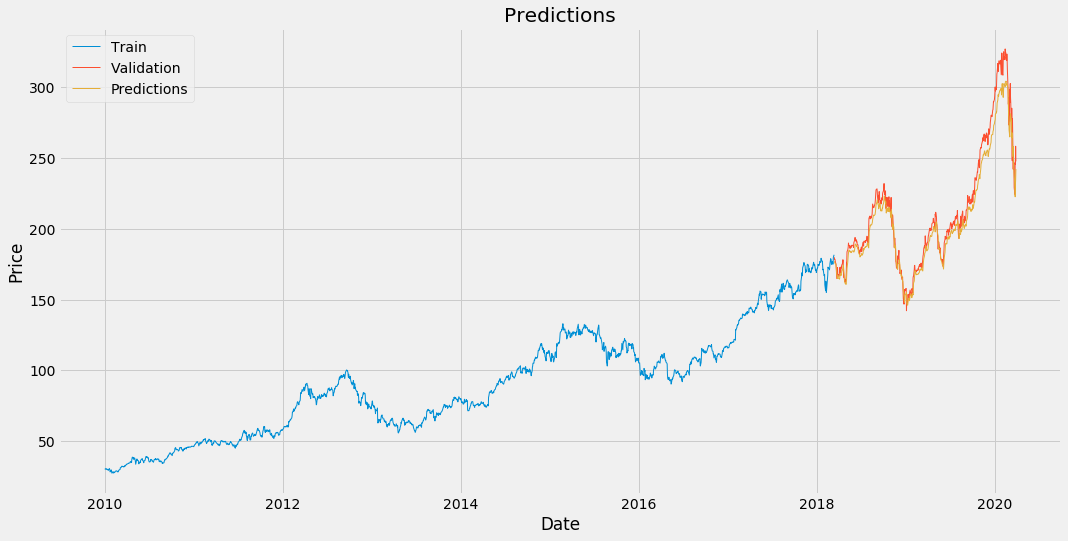

In [18]:
## plot the results
train = data[:train_data_len]
valid = data[train_data_len:]
valid['Predictions'] = predictions

plt.figure(figsize=(16,8))
plt.title('Predictions')
plt.plot(train['Close'], linewidth=1)
plt.plot(valid[['Close', 'Predictions']], linewidth=1)
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(['Train', 'Validation', 'Predictions'], loc='upper left')

plt.show()

In [19]:
## make predictions on new data..
quote = web.DataReader(stock, data_source = datasource, start=sDate, end=eDate, retry_count=retryCount)
new_df = quote.filter(['Close'])

## get last 60 days price
last_60_days = new_df[-slots:].values
last_60_days_scaled = scaler.transform(last_60_days)

X_test = []
X_test.append(last_60_days_scaled)                                       
## create array
X_test = np.array(X_test)
## reshape
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
                                       
## make predictions..
predicted_price = model.predict(X_test)
predicted_price = scaler.inverse_transform(predicted_price)
                                       
predicted_price

array([[240.55232]], dtype=float32)

In [20]:
actual = web.DataReader(stock, data_source=datasource, start='2020-03-30', end='2020-03-30', retry_count=retryCount)
actual_price = actual['Close']
actual_price

Date
2020-03-30    254.809998
Name: Close, dtype: float64

In [21]:
actual

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-03-30,255.5,249.399994,250.740005,254.809998,37900589,254.809998
